In [1]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences 

Using TensorFlow backend.


处理一下tensorflow的问题：

In [2]:
import keras.backend as K

if K.backend() == "tensorflow":
    config = K.tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = K.tf.Session(config=config)
    K.set_session(session)

读数据：

In [3]:
with open("data/all.txt") as f:
    all_data = [line.strip().split(";") for line in f]

In [4]:
data_x_team_id_raw = all_data[0::9]
data_y_raw = all_data[1::9]
data_x_team_abbr_raw = all_data[2::9]
data_x_home_min_raw = all_data[3::9]
data_x_home_id_raw = all_data[4::9]
data_x_home_name_raw = all_data[5::9]
data_x_visitor_min_raw = all_data[6::9]
data_x_visitor_id_raw = all_data[7::9]
data_x_visitor_name_raw = all_data[8::9]

In [5]:
def flatten(x):
    for seq in x:
        for s in seq:
            yield s

把球队名称和ID对应：

In [6]:
id2team = dict(zip(flatten(data_x_team_id_raw), flatten(data_x_team_abbr_raw)))
id2player = dict(zip(flatten(data_x_home_id_raw + data_x_visitor_id_raw), 
                     flatten(data_x_home_name_raw + data_x_visitor_name_raw)))
team2id = dict(zip(flatten(data_x_team_abbr_raw), flatten(data_x_team_id_raw)))
player2id = dict(zip(flatten(data_x_home_name_raw + data_x_visitor_name_raw),
                     flatten(data_x_home_id_raw + data_x_visitor_id_raw)))

In [7]:
print "total_teams", len(id2team)

total_teams 30


In [8]:
print "total_players", len(id2player)

total_players 898


将球队id和队员id序列化方便Embbedding：

In [9]:
tid2index = {tid: idx for idx, tid in enumerate(id2team)}
index2tid = {idx: tid for idx, tid in enumerate(id2team)}

pid2index = {pid: idx+1 for idx, pid in enumerate(id2player)}
index2pid = {idx+1: pid for idx, pid in enumerate(id2player)}

将时间转化为秒：

In [10]:
def str2time(ms):
    m, s = ms.split(":")
    return int(m) * 60 + int(s)

读取数据：

In [11]:
data_x_team_id = np.array(map(lambda x: [tid2index[tid] for tid in x], data_x_team_id_raw))
data_x_home_id   = pad_sequences(map(lambda x: [pid2index[pid] for pid in x], data_x_home_id_raw), padding="post", maxlen=13)
data_x_vistor_id = pad_sequences(map(lambda x: [pid2index[pid] for pid in x], data_x_visitor_id_raw), padding="post", maxlen=13)
data_x_home_min    = pad_sequences(map(lambda x: [str2time(ms) for ms in x], data_x_home_min_raw), padding="post", maxlen=13)
data_x_visitor_min = pad_sequences(map(lambda x: [str2time(ms) for ms in x], data_x_visitor_min_raw), padding="post", maxlen=13)

data_x_home_min = 5 * data_x_home_min.astype(K.floatx()) / data_x_home_min.sum(axis=-1)[:,None]
data_x_visitor_min = 5 * data_x_visitor_min.astype(K.floatx()) / data_x_visitor_min.sum(axis=-1)[:,None]

data_y = np.array(data_y_raw, dtype=int)

构造比分预测模型：

In [12]:
x_t = Input((2,), name="team_id") 

x_h_id = Input((13,), name="home_player_id")
x_h_min = Input((13,1), name="home_player_time")

x_v_id = Input((13,), name="visitor_player_id")
x_v_min = Input((13,1), name="visitor_player_time")

emb_dim = 256

team_emb = Sequential(name="team_emb")
team_emb.add(Embedding(input_dim=30, output_dim=emb_dim, input_length=2))
team_emb.add(Flatten())

player_emb = Sequential(name="player_emb")
player_emb.add(Embedding(input_dim=len(id2player)+1, output_dim=emb_dim, input_length=13))

feat_t = team_emb(x_t)

feat_h_id = player_emb(x_h_id)
feat_h = dot([x_h_min, feat_h_id], axes=1, name="home_player_sum")
feat_h = Reshape((emb_dim,), name="home_feat")(feat_h)

feat_v_id = player_emb(x_v_id)
feat_v = dot([x_v_min, feat_v_id], axes=1, name="visitor_player_sum")
feat_v = Reshape((emb_dim,), name="visitor_feat")(feat_v)

feat = concatenate([feat_t, feat_h, feat_v], name="all_feat")

hid = Dense(256, activation="relu", name="hidden_1")(feat)
hid = Dropout(0.2, name="dropout_1")(hid)
hid = Dense(128, activation="relu", name="hidden_2")(hid)
hid = Dropout(0.2, name="dropout_2")(hid)
score = Dense(2, activation="relu", name="score")(hid)

In [14]:
model = Model(inputs=[x_t, x_h_id, x_h_min, x_v_id, x_v_min], outputs=score)


def win(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_pred, axis=-1), K.argmax(y_true, axis=-1)))

model.compile(optimizer="adam", loss="mae", metrics=[win])

In [15]:
np.random.seed(1105)

idx = np.arange(len(data_y))
np.random.shuffle(idx)

train_idx = idx[600:]
valid_idx = idx[:600]

In [16]:
len(idx)

6632

In [17]:
hist = model.fit([data_x_team_id[train_idx], 
                  data_x_home_id[train_idx], data_x_home_min[train_idx, :, None], 
                  data_x_vistor_id[train_idx], data_x_visitor_min[train_idx, :, None]],
                 data_y[train_idx],
                 validation_data = ([data_x_team_id[valid_idx], 
                                     data_x_home_id[valid_idx], data_x_home_min[valid_idx, :, None], 
                                     data_x_vistor_id[valid_idx], data_x_visitor_min[valid_idx, :, None]],
                                    data_y[valid_idx]),
                 verbose=0,
                 epochs=30)

In [18]:
hist.history["val_loss"]

[10.165847600301106,
 9.9543780390421546,
 9.8001865132649737,
 10.289466730753581,
 9.228977038065592,
 11.430291798909506,
 9.3323127492268885,
 9.1152853902180997,
 9.1859752019246415,
 9.4495480346679681,
 9.5419914118448901,
 9.3206252034505201,
 9.0971596018473306,
 9.0549177932739262,
 9.2275110244750973,
 9.3106695048014316,
 9.1169172541300458,
 9.3980016962687181,
 9.1642890930175778,
 9.702613741556803,
 9.2596215184529616,
 9.3760626475016284,
 8.9202607472737636,
 9.2350659434000644,
 9.2720768737792962,
 10.19280756632487,
 9.3464718373616531,
 9.4991256459554041,
 9.2756049474080395,
 9.1515356826782224]

预测测试数据正确率：

In [20]:
data_t = model.predict([data_x_team_id[valid_idx], 
                        data_x_home_id[valid_idx], data_x_home_min[valid_idx , :, None], 
                        data_x_vistor_id[valid_idx], data_x_visitor_min[valid_idx , :, None]])

print np.mean(data_t.argmax(axis=-1) == data_y[valid_idx].argmax(axis=-1))
print np.mean(0 == data_y[valid_idx].argmax(axis=-1))

0.656666666667
0.563333333333


测试集上的预测比分：

In [21]:
data_t

array([[ 118.31840515,  106.11000824],
       [  99.41278076,   93.19446564],
       [ 100.38309479,   99.36334991],
       ..., 
       [  99.76564026,   93.42744446],
       [  91.10274506,   97.74150848],
       [ 103.73945618,   95.22878265]], dtype=float32)

真实比分：

In [24]:
data_y[valid_idx]

array([[116,  92],
       [107, 112],
       [ 94, 100],
       ..., 
       [105, 109],
       [112, 100],
       [ 95,  94]])

In [22]:
data_x_team_abbr = np.array(data_x_team_abbr_raw)

In [23]:
data_x_team_abbr[valid_idx]

array([['SAC', 'LAL'],
       ['LAL', 'HOU'],
       ['MIN', 'NYK'],
       ..., 
       ['WAS', 'MIL'],
       ['CHA', 'GSW'],
       ['SAC', 'WAS']], 
      dtype='|S3')

训练集上的比分和队伍：

In [25]:
data_p = model.predict([data_x_team_id[train_idx], 
                        data_x_home_id[train_idx], data_x_home_min[train_idx , :, None], 
                        data_x_vistor_id[train_idx], data_x_visitor_min[train_idx , :, None]])

In [26]:
data_p

array([[ 111.05187225,   93.65827179],
       [ 103.43552399,  105.09658813],
       [ 108.43019104,  107.60032654],
       ..., 
       [  85.79730988,   81.65973663],
       [ 107.5667038 ,  106.44389343],
       [  99.8336792 ,   98.61862183]], dtype=float32)

In [27]:
data_x_team_abbr[train_idx]

array([['HOU', 'PHI'],
       ['DEN', 'ATL'],
       ['PHX', 'MIN'],
       ..., 
       ['DET', 'IND'],
       ['LAL', 'BKN'],
       ['MIN', 'UTA']], 
      dtype='|S3')

真实比分：

In [28]:
data_y[train_idx]

array([[120,  98],
       [105, 119],
       [107, 104],
       ..., 
       [ 77,  88],
       [105, 114],
       [ 92,  94]])

模型结构：

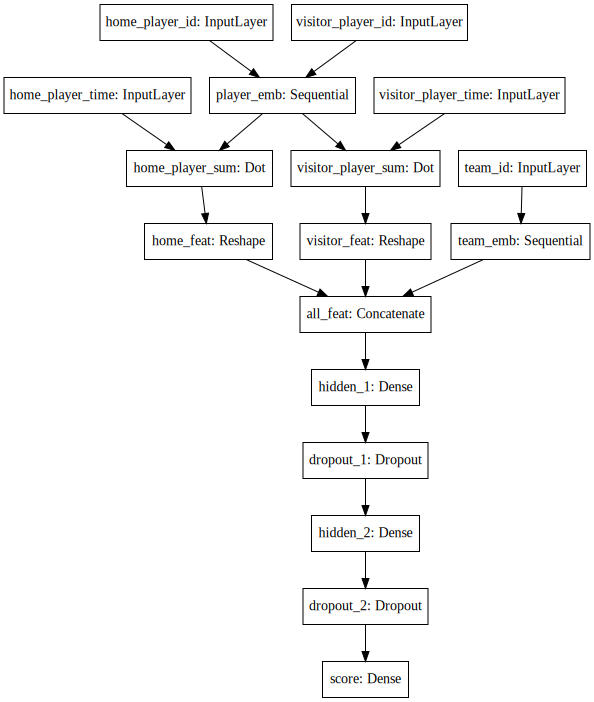

In [29]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, to_file="model.png")
SVG(model_to_dot(model).create(prog='dot', format='svg'))

关公战秦琼：

In [34]:
names1 = "Mike Miller, LeBron James, Chris Bosh, Dwyane Wade, Mario Chalmers," \
         " Ray Allen, Shane Battier, Chris Andersen, Udonis Haslem"
pid1 = [[pid2index[player2id[name]] for name in names1.split(", ")]]
min1 = [[19,47,28,39,40,20,29,19,2]]

In [35]:
names2 = "LeBron James, JR Smith, Kevin Love, Kyrie Irving, Tristan Thompson, Richard Jefferson, Mo Williams, Iman Shumpert"
pid2 = [[pid2index[player2id[name]] for name in names2.split(", ")]]
min2 = [[47,39,30,43,32,26,5,19]]

In [36]:
pid1 = pad_sequences(pid1, maxlen=13, padding="post")
pid2 = pad_sequences(pid2, maxlen=13, padding="post")
min1 = pad_sequences(min1, maxlen=13, padding="post")
min2 = pad_sequences(min2, maxlen=13, padding="post")

min1 = 5 * min1.astype(np.float32) / min1.sum()
min2 = 5 * min2.astype(np.float32) / min2.sum()

In [37]:
tid2index[team2id["MIA"]]

4

In [38]:
tid2index[team2id["CLE"]]

14

In [39]:
model.predict([np.array([[14, 4]]), pid2, min2[..., None], pid1, min1[..., None]])

array([[ 102.45483398,  100.24012756]], dtype=float32)

In [40]:
model.predict([np.array([[4, 14]]), pid1, min1[..., None], pid2, min2[..., None]])

array([[ 110.89669037,  106.30657196]], dtype=float32)